In [19]:
# Define the scenario
scen = "hist"  # Options: "hist" or "ssp"

# Define the target coordinates based on the ship
ship = "gj"  # Options: "gj" or "gb"

if ship == "gj":
    # Coordinates for ship "gj"
    target_lon = 119.5394
    target_lat = 23.35106
elif ship == "gb":
    # Coordinates for ship "gb"
    target_lon = 119.5565
    target_lat = 23.3495
else:
    raise ValueError(f"Unknown ship type: {ship}")

# Print the configured parameters for validation
print(f"Scenario: {scen}")
print(f"Ship: {ship}")
print(f"Target coordinates: Longitude = {target_lon}, Latitude = {target_lat}")


Scenario: hist
Ship: gj
Target coordinates: Longitude = 119.5394, Latitude = 23.35106


In [20]:
import xarray as xr

# File paths
base_path = "/lfs/home/ioloi/lfs_dir/project_UCH/data/d00_30yr/"
salt_file = f"{base_path}ITRI_penghu.d00_{scen}_salt_L0.nc"
temp_file = f"{base_path}ITRI_penghu.d00_{scen}_temp_L0.nc"
u_file = f"{base_path}ITRI_penghu.d00_{scen}_u_eastward_L0.nc"
v_file = f"{base_path}ITRI_penghu.d00_{scen}_v_northward_L0.nc"

try:
    # Load datasets
    salt_data = xr.open_dataset(salt_file)
    temp_data = xr.open_dataset(temp_file)
    u_data = xr.open_dataset(u_file)
    v_data = xr.open_dataset(v_file)

    # Ensure lon_rho and lat_rho are accessible as coordinates
    lon_rho = salt_data['lon_rho']
    lat_rho = salt_data['lat_rho']

    # Select level 0 (s_rho=0)
    salt_level_0 = salt_data['salt'].isel(s_rho=0)
    temp_level_0 = temp_data['temp'].isel(s_rho=0)
    u_level_0 = u_data['u_eastward'].isel(s_rho=0)
    v_level_0 = v_data['v_northward'].isel(s_rho=0)

    # Find the nearest grid point index
    distance = ((lon_rho - target_lon)**2 + (lat_rho - target_lat)**2)
    nearest_idx = distance.argmin(dim=['eta_rho', 'xi_rho'])



    # Extract the nearest values
    salt_point = salt_level_0.isel(eta_rho=nearest_idx['eta_rho'], xi_rho=nearest_idx['xi_rho'])
    temp_point = temp_level_0.isel(eta_rho=nearest_idx['eta_rho'], xi_rho=nearest_idx['xi_rho'])
    u_point = u_level_0.isel(eta_rho=nearest_idx['eta_rho'], xi_rho=nearest_idx['xi_rho'])
    v_point = v_level_0.isel(eta_rho=nearest_idx['eta_rho'], xi_rho=nearest_idx['xi_rho'])

    
    # Print the results
    print(f"Salt value at ({target_lon}°E, {target_lat}°N): {salt_point.values}")
    print(f"Temperature value at ({target_lon}°E, {target_lat}°N): {temp_point.values}")

except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Salt value at (119.5394°E, 23.35106°N): [34.352425 34.352436 34.352543 ... 34.6365   34.637672 34.63888 ]
Temperature value at (119.5394°E, 23.35106°N): [19.936646 19.935427 19.934423 ... 21.887197 21.87986  21.872993]


In [21]:
!pip install PyCO2SYS
import PyCO2SYS as pyco2

Defaulting to user installation because normal site-packages is not writeable


In [22]:
salinity = salt_point.values
temperature = temp_point.values

kwargs = dict(
    par1_type=1,
    par1=2400,
    par2_type=3,
    par2=8.191304348,
    salinity=33.83478261,
    #salinity=salinity,
    temperature=25.76956522,
    temperature_out=temperature,
    pressure=1,
    pressure_out=15,
    total_silicate=50,
    total_phosphate=2,
    opt_pH_scale=1,
    opt_k_carbonic=4,
    opt_k_bisulfate=1,
    opt_total_borate=1,
)

results = pyco2.sys(**kwargs)
pH_value = results["pH_sws_out"]
print(f"pH Value: {pH_value}")


pH Value: [8.27069838 8.27071735 8.27073296 ... 8.24048918 8.24060229 8.24070814]


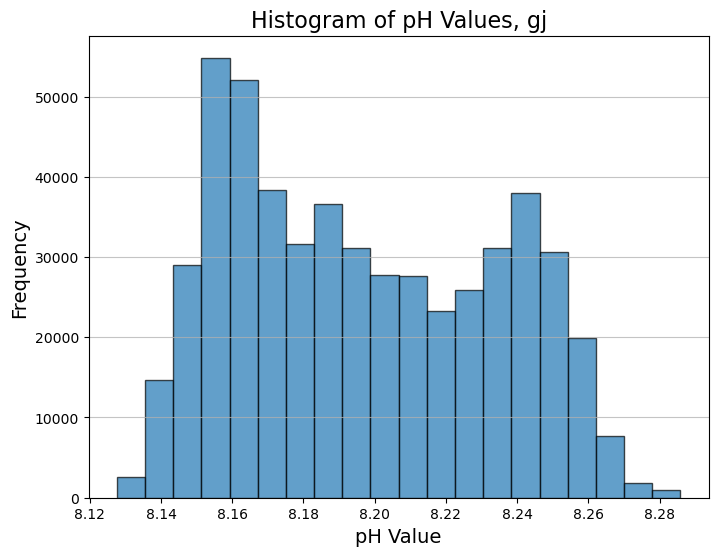

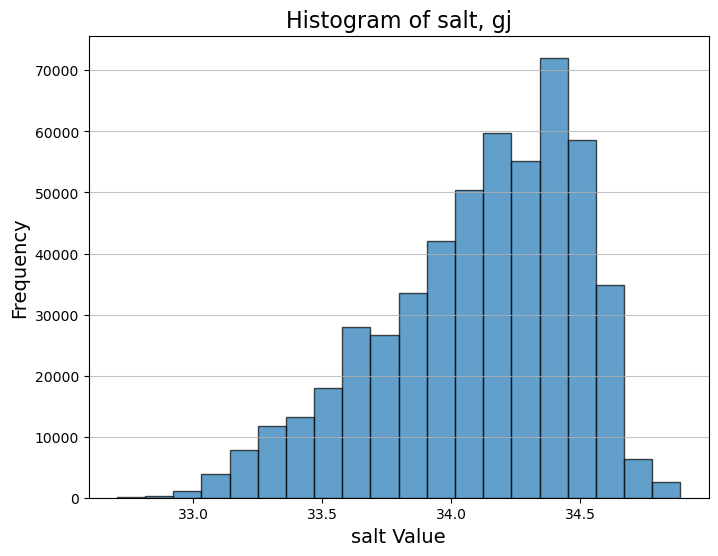

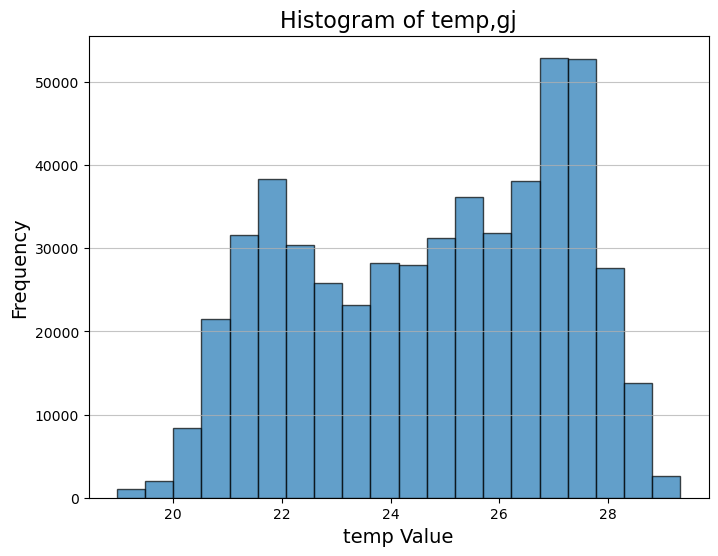

In [23]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np


# Plot the histogram of pH values
plt.figure(figsize=(8, 6))
plt.hist(pH_value, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of pH Values, "+ship, fontsize=16)
plt.xlabel("pH Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot the histogram of pH values
plt.figure(figsize=(8, 6))
plt.hist(salt_point, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of salt, "+ship, fontsize=16)
plt.xlabel("salt Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot the histogram of pH values
plt.figure(figsize=(8, 6))
plt.hist(temp_point, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of temp,"+ship, fontsize=16)
plt.xlabel("temp Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [24]:
import xarray as xr

# Assuming `salt_data`, `salt_point`, `temp_point`, and `pH_value` are preloaded
# Extract the time coordinate from the salt_data
time = salt_data['ocean_time'].data  # Ensure it's a 1D array

# Extract raw data from DataArrays if necessary
salt_point_data = salt_point.data
temp_point_data = temp_point.data
u_point_data = u_point.data
v_point_data = v_point.data
pH_value_data = pH_value.data

speed = np.sqrt(u_point_data**2 + v_point_data**2)


# Create the Dataset
ds = xr.Dataset(
    {
        "salt": (["time"], salt_point_data),
        "temp": (["time"], temp_point_data),
        "speed": (["time"], speed),
        "pH": (["time"], pH_value_data),
    },
    coords={"time": time},  # Use 1D time as the coordinate
)

# Add metadata (optional)
ds["salt"].attrs["units"] = "PSU"
ds["salt"].attrs["long_name"] = "Salinity"
ds["temp"].attrs["units"] = "Celsius"
ds["temp"].attrs["long_name"] = "Temperature"
ds["speed"].attrs["units"] = "ms-1"
ds["speed"].attrs["long_name"] = "current speed"
ds["pH"].attrs["units"] = "pH"
ds["pH"].attrs["long_name"] = "pH Value"

# Save to a NetCDF file
output_file = "/lfs/home/ioloi/lfs_dir/project_UCH/data/d00_30yr/ITRI_penghu.d00_"+scen+"_"+ship+".nc"
ds.to_netcdf(output_file)

print(f"NetCDF file '{output_file}' saved successfully.")


NetCDF file '/lfs/home/ioloi/lfs_dir/project_UCH/data/d00_30yr/ITRI_penghu.d00_hist_gj.nc' saved successfully.
